In [2]:
import fastbook

fastbook.setup_book()

# Week 5 - Hotel Reservation Predictions

This dataset originated from this [Kaggle Source](https://www.kaggle.com/datasets/ahsan81/hotel-reservations-classification-dataset?datasetId=2783627&sortBy=voteCount). The online hotel reservation channels have dramatically changed booking possibilities and customers’ behavior. A significant number of hotel reservations are called-off due to cancellations or no-shows. The typical reasons for cancellations include change of plans, scheduling conflicts, etc. This is often made easier by the option to do so free of charge or preferably at a low cost which is beneficial to hotel guests but it is a less desirable and possibly revenue-diminishing factor for hotels to deal with.

Objective: **Can you predict if the customer is going to honor the reservation or cancel it?**

## Data Defintions

| Variable Name | Meaning |
|--------------|------------|
  | booking_ID | Unique identifier of each booking|
   | no_of_adults | Number of adults|
   | no_of_children | Number of Children |
   | no_of_weekend_nights | Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel|
   | no_of_week_nights | Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel
   | type_of_meal_plan | Type of meal plan booked by the customer|
   | required_car_parking_space | Does the customer require a car parking space? (0 - No, 1- Yes) |
   | room_type_reserved | Type of room reserved by the customer. The values are ciphered (encoded) by INN Hotels. |
   | lead_time | Number of days between the date of booking and the arrival date |
   | arrival_year | Year of arrival date |
   | arrival_month | Month of arrival date |
   | arrival_date | Date of the month |
   | market_segment_type | Market segment designation. |
   | repeated_guest | Is the customer a repeated guest? (0 - No, 1- Yes) |
   | no_of_previous_cancellations | Number of previous bookings that were canceled by the customer prior to the current booking |
   | no_of_previous_bookings_not_canceled | Number of previous bookings not canceled by the customer prior to the current booking |
   | avg_price_per_room | Average price per day of the reservation; prices of the rooms are dynamic. (in euros) |
   | no_of_special_requests | Total number of special requests made by the customer (e.g. high floor, view from the room, etc) |
   | booking_status | Flag indicating if the booking was canceled or not.|

## Set-Up

In [3]:
from fastai.tabular.all import *
import pandas as pd

import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier


from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

import seaborn as sns

In [4]:
path = Path('C:/Users/saketm1/Desktop/ML_Projects/Week_5_hotel/Hotel_Reservations.csv')

In [5]:
df = pd.read_csv(path)

## EDA

In [6]:
df.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


In [8]:
df.describe(include='all',datetime_is_numeric=True)

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
count,36275,36275.000000,36275.000000,36275.000000,36275.000000,36275,36275.000000,36275,36275.000000,36275.000000,36275.000000,36275.000000,36275,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275
unique,36275,NaN,NaN,NaN,NaN,4,NaN,7,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,2
top,INN00001,NaN,NaN,NaN,NaN,Meal Plan 1,NaN,Room_Type 1,NaN,NaN,NaN,NaN,Online,NaN,NaN,NaN,NaN,NaN,Not_Canceled
freq,1,NaN,NaN,NaN,NaN,27835,NaN,28130,NaN,NaN,NaN,NaN,23214,NaN,NaN,NaN,NaN,NaN,24390
mean,NaN,1.844962,0.105279,0.810724,2.204300,NaN,0.030986,NaN,85.232557,2017.820427,7.423653,15.596995,NaN,0.025637,0.023349,0.153411,103.423539,0.619655,NaN
std,NaN,0.518715,0.402648,0.870644,1.410905,NaN,0.173281,NaN,85.930817,0.383836,3.069894,8.740447,NaN,0.158053,0.368331,1.754171,35.089424,0.786236,NaN
min,NaN,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,NaN,0.000000,2017.000000,1.000000,1.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,NaN,2.000000,0.000000,0.000000,1.000000,NaN,0.000000,NaN,17.000000,2018.000000,5.000000,8.000000,NaN,0.000000,0.000000,0.000000,80.300000,0.000000,NaN
50%,NaN,2.000000,0.000000,1.000000,2.000000,NaN,0.000000,NaN,57.000000,2018.000000,8.000000,16.000000,NaN,0.000000,0.000000,0.000000,99.450000,0.000000,NaN
75%,NaN,2.000000,0.000000,2.000000,3.000000,NaN,0.000000,NaN,126.000000,2018.000000,10.000000,23.000000,NaN,0.000000,0.000000,0.000000,120.000000,1.000000,NaN


In [9]:
df.drop(['Booking_ID'],axis=1,inplace=True)

In [10]:
df.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


In [11]:
map = {'Not_Canceled': 0, 'Canceled': 1}
df.booking_status.replace(map,inplace=True)
#not canceled = 0, canceled = 1, we like 0 we dont like 1

In [12]:
df.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,0
1,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,0
2,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,1
3,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,1
4,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,1


In [13]:
df.describe()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,arrival_year,arrival_month,arrival_date,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
count,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000
mean,1.844962,0.105279,0.810724,2.204300,0.030986,85.232557,2017.820427,7.423653,15.596995,0.025637,0.023349,0.153411,103.423539,0.619655,0.327636
std,0.518715,0.402648,0.870644,1.410905,0.173281,85.930817,0.383836,3.069894,8.740447,0.158053,0.368331,1.754171,35.089424,0.786236,0.469358
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,0.000000,17.000000,2018.000000,5.000000,8.000000,0.000000,0.000000,0.000000,80.300000,0.000000,0.000000
50%,2.000000,0.000000,1.000000,2.000000,0.000000,57.000000,2018.000000,8.000000,16.000000,0.000000,0.000000,0.000000,99.450000,0.000000,0.000000
75%,2.000000,0.000000,2.000000,3.000000,0.000000,126.000000,2018.000000,10.000000,23.000000,0.000000,0.000000,0.000000,120.000000,1.000000,1.000000
max,4.000000,10.000000,7.000000,17.000000,1.000000,443.000000,2018.000000,12.000000,31.000000,1.000000,13.000000,58.000000,540.000000,5.000000,1.000000


In [14]:
df.isnull().sum()

no_of_adults                            0
no_of_children                          0
no_of_weekend_nights                    0
no_of_week_nights                       0
type_of_meal_plan                       0
required_car_parking_space              0
room_type_reserved                      0
lead_time                               0
arrival_year                            0
arrival_month                           0
arrival_date                            0
market_segment_type                     0
repeated_guest                          0
no_of_previous_cancellations            0
no_of_previous_bookings_not_canceled    0
avg_price_per_room                      0
no_of_special_requests                  0
booking_status                          0
dtype: int64

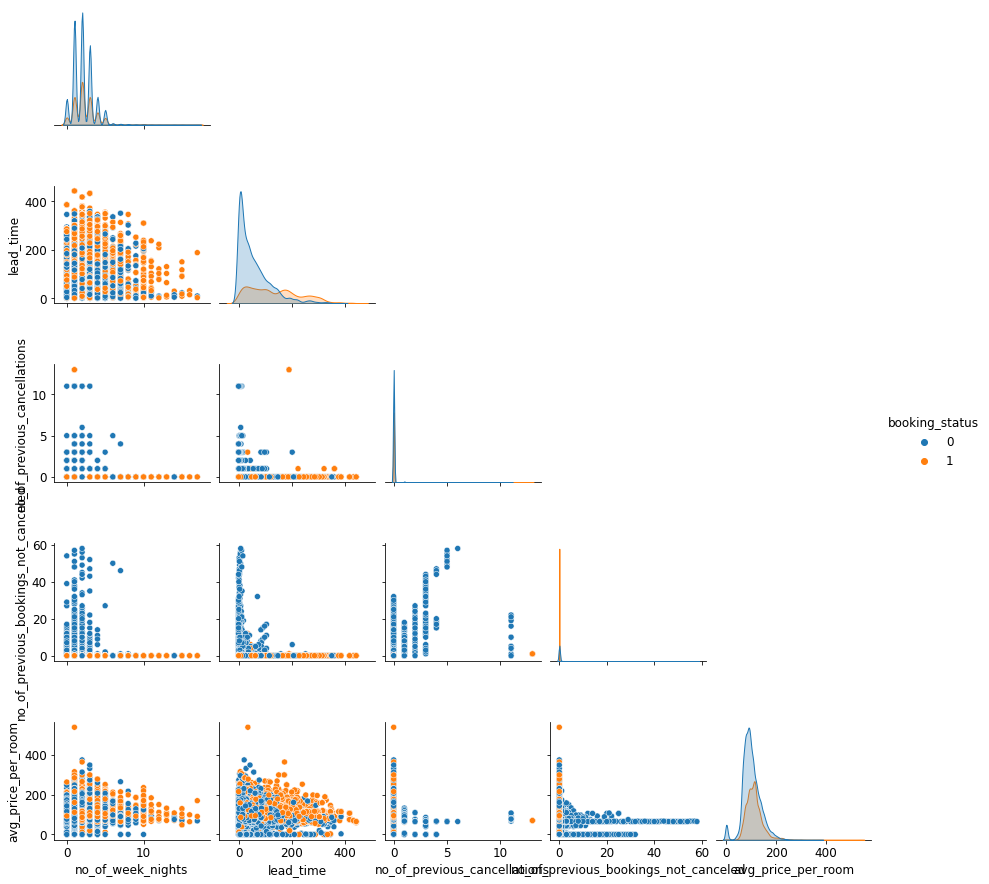

In [15]:
sns.pairplot(data=df, hue='booking_status', 
        vars=['no_of_week_nights','lead_time',
              'no_of_previous_cancellations','no_of_previous_bookings_not_canceled','avg_price_per_room'],
             corner=True)

The first things that pop out to me is that most of the users that are making cancelations have no previous cancelations, while there is just a few users that repeatedly cancelations it does not seem to be the majority.  Another thing we see is that a large number of customers have relatively little to no lead time also don't often cancel their bookings, however the longer the lead time we see more cancelations. 

<AxesSubplot:xlabel='arrival_month', ylabel='count'>

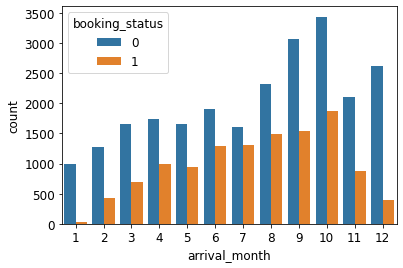

In [16]:
sns.countplot(data=df,x='arrival_month', hue='booking_status')

## Model Buliding

In [17]:
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

In [18]:
object_cols = ['type_of_meal_plan','room_type_reserved','market_segment_type']
OH_cols = pd.DataFrame(OH_encoder.fit_transform(df[object_cols]))
OH_cols.index = df.index
num_df = df.drop(object_cols,axis=1)
oh_df = pd.concat([num_df,OH_cols], axis=1)

C:\Users\saketm1\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [19]:
y = oh_df.booking_status
x = oh_df.drop(['booking_status'], axis=1)

In [20]:
oversample = SMOTE()
x.columns = x.columns.astype(str)
smote_x,smote_y = oversample.fit_resample(x,y)

In [21]:
x_train,x_val,y_train,y_val = train_test_split(x,y)
smote_x_train,smote_x_val,smote_y_train,smote_y_val = train_test_split(smote_x,smote_y)

In [22]:
kfold = StratifiedKFold(n_splits=5,random_state=1,shuffle=True)
accuracy_list = {}

log_model = LogisticRegression(solver='newton-cholesky', random_state=2)
knn_model = KNeighborsClassifier(n_neighbors=3)
xgbr = xgb.XGBRegressor() 
xgbr_oh = xgb.XGBRegressor()

xgbr.fit(x_train,y_train)
xgbr_oh.fit(smote_x_train,smote_y_train)

model_list = [log_model,knn_model,xgbr,xgbr_oh]

for model in model_list:
    if model==xgbr_oh:
        score = cross_val_score(model, smote_x_val, smote_y_val, cv=kfold)
    elif model==xgbr:
        score = cross_val_score(model, x_val, y_val, cv=kfold)
    else:
        score = cross_val_score(model,smote_x_train,smote_y_train,cv=kfold)
    accuracy_list[model]=score.mean()

print(accuracy_list)

{LogisticRegression(random_state=2, solver='newton-cholesky'): 0.7935219352193522, KNeighborsClassifier(n_neighbors=3): 0.8300396337296705, XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...): 0.5716273127385918, XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, c

In [23]:
splits = RandomSplitter(valid_pct=0.25)(range_of(df))
to = TabularPandas(df, procs=[Categorify, FillMissing,Normalize],
            cat_names = ['type_of_meal_plan','room_type_reserved','market_segment_type','required_car_parking_space',
                        'repeated_guest','no_of_previous_cancellations','no_of_previous_bookings_not_canceled'],
            cont_names = ['no_of_adults','no_of_children','no_of_weekend_nights','no_of_week_nights'
                          ,'lead_time','arrival_year','arrival_month','arrival_date','avg_price_per_room'],
            y_names='booking_status',
            splits=splits)

In [24]:
dls = to.dataloaders()
dls.show_batch()

,type_of_meal_plan,room_type_reserved,market_segment_type,required_car_parking_space,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,lead_time,arrival_year,arrival_month,arrival_date,avg_price_per_room,booking_status
0,Meal Plan 1,Room_Type 4,Online,0,0,0,0,2.0,-3.849568e-09,-1.566257e-08,4.000000e+00,39.999999,2018.0,12.0,7.0,96.910004,0.0
1,Not Selected,Room_Type 1,Online,0,0,0,0,2.0,-3.849568e-09,2.000000e+00,3.000000e+00,26.999998,2018.0,6.0,12.0,105.839996,1.0
2,Not Selected,Room_Type 1,Online,0,0,0,0,2.0,-3.849568e-09,2.000000e+00,2.000000e+00,98.000000,2018.0,5.0,29.0,109.650002,0.0
3,Meal Plan 1,Room_Type 6,Online,0,0,0,0,2.0,2.000000e+00,-1.566257e-08,3.000000e+00,55.000001,2018.0,9.0,20.0,207.899993,1.0
4,Meal Plan 1,Room_Type 1,Online,0,0,0,0,2.0,-3.849568e-09,2.000000e+00,-7.205949e-08,95.000000,2018.0,11.0,20.0,90.000000,1.0
5,Meal Plan 1,Room_Type 1,Offline,0,0,0,0,2.0,-3.849568e-09,-1.566257e-08,2.000000e+00,79.000000,2017.0,11.0,13.0,74.999999,0.0
6,Meal Plan 1,Room_Type 1,Online,0,0,0,0,2.0,-3.849568e-09,2.000000e+00,-7.205949e-08,91.000000,2018.0,8.0,21.0,126.900002,0.0
7,Meal Plan 1,Room_Type 5,Corporate,0,0,0,0,1.0,-3.849568e-09,1.000000e+00,2.000000e+00,289.999998,2018.0,12.0,12.0,106.000000,0.0
8,Meal Plan 1,Room_Type 4,Online,0,0,0,0,3.0,-3.849568e-09,1.000000e+00,3.000000e+00,27.999999,2018.0,6.0,27.0,175.399993,1.0
9,Meal Plan 2,Room_Type 1,Offline,0,0,0,0,2.0,-3.849568e-09,-1.566257e-08,2.000000e+00,346.000009,2018.0,9.0,13.0,115.000000,1.0


In [25]:
learn2 = tabular_learner(dls, metrics=accuracy)

In [26]:
learn2.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,time
0,0.166894,0.154639,0.677437,00:08
1,0.150920,0.148175,0.677437,00:08
2,0.147227,0.139995,0.677437,00:07


In [27]:
dls.show_batch()

,type_of_meal_plan,room_type_reserved,market_segment_type,required_car_parking_space,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,lead_time,arrival_year,arrival_month,arrival_date,avg_price_per_room,booking_status
0,Meal Plan 1,Room_Type 1,Online,0,0,0,0,2.0,1.000000e+00,1.000000e+00,3.000000e+00,1.800000e+02,2018.0,8.0,11.0,114.750000,1.0
1,Meal Plan 1,Room_Type 1,Complementary,0,0,0,0,2.0,-3.849568e-09,-1.566257e-08,-7.205949e-08,-7.254831e-07,2018.0,6.0,22.0,0.000003,0.0
2,Meal Plan 1,Room_Type 4,Online,0,0,0,0,3.0,-3.849568e-09,1.000000e+00,2.000000e+00,2.200000e+01,2018.0,7.0,8.0,186.999999,0.0
3,Meal Plan 1,Room_Type 1,Online,0,0,0,0,2.0,-3.849568e-09,-1.566257e-08,2.000000e+00,5.900000e+01,2018.0,6.0,22.0,99.900001,0.0
4,Meal Plan 1,Room_Type 1,Offline,0,0,0,0,2.0,-3.849568e-09,-1.566257e-08,2.000000e+00,3.000000e+01,2018.0,6.0,2.0,140.000001,0.0
5,Meal Plan 2,Room_Type 1,Offline,0,0,0,0,2.0,-3.849568e-09,-1.566257e-08,2.000000e+00,2.650000e+02,2018.0,6.0,24.0,115.000000,1.0
6,Not Selected,Room_Type 1,Online,1,0,0,0,2.0,-3.849568e-09,-1.566257e-08,2.000000e+00,1.770000e+02,2018.0,8.0,16.0,103.500000,1.0
7,Meal Plan 1,Room_Type 1,Online,0,0,0,0,1.0,-3.849568e-09,-1.566257e-08,4.000000e+00,6.000002e+00,2017.0,10.0,6.0,148.500002,0.0
8,Meal Plan 1,Room_Type 4,Online,0,0,0,0,3.0,-3.849568e-09,-1.566257e-08,3.000000e+00,5.000001e+00,2018.0,4.0,21.0,156.999999,0.0
9,Not Selected,Room_Type 1,Online,0,0,0,0,2.0,-3.849568e-09,2.000000e+00,1.000000e+00,1.810000e+02,2018.0,8.0,27.0,85.500001,1.0
